Used Bike Price Prediction Pipeline
This notebook implements an end-to-end machine learning pipeline for bike price prediction. It consists of three main stages:

Scraper: Collecting data from car.gr using DrissionPage.

Cleanup: Preprocessing text data and extracting features (Brand/Model).

Training & Evaluation: Training multiple regression models and visualizing performance.

In [1]:
import os
import time
import re
import csv
import joblib
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML Imports
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Scraper Import
# Note: DrissionPage requires a Chromium browser installed on the system.
from DrissionPage import ChromiumPage
from DrissionPage._configs.chromium_options import ChromiumOptions

# Configuration
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Create necessary directories
for directory in ['MODEL_DATA', 'models', 'results', 'visualizations']:
    os.makedirs(directory, exist_ok=True)
    print(f"Directory ready: {directory}/")

Directory ready: MODEL_DATA/
Directory ready: models/
Directory ready: results/
Directory ready: visualizations/


Part 1: Data Scraping
Note: Set RUN_SCRAPER = True to execute the scraping process. This opens a browser instance and may take a significant amount of time depending on the number of pages. If you already have MODEL_DATA/raw_data.csv, you can skip this step.

In [3]:
RUN_SCRAPER = False  # Set to True to run the scraper
PAGES_TO_SCRAPE = 400
USER_DATA_PATH = r'/browser_user_data'

def write_bike_to_csv(writer, bike_text):
    year_pattern = r'(19\d{2}|20\d{2})\s\n'
    year_match = re.search(year_pattern, bike_text)

    year = "Unknown"
    model = "Unknown"

    if year_match:
        year = year_match.group(1)
        # To get the model, we look at the line containing that specific year pattern
        lines = bike_text.splitlines()
        for i, line in enumerate(lines):
            if year in line:
                # Clean up the line (remove "1 / 16" or "Προωθημένη" if present)
                clean_line = re.sub(r'(\d+ / \d+)|Προωθημένη|Με ζημιά', '', line)
                model = clean_line.replace(year, '').strip()
                break

    price_match = re.search(r'([\d.]+)\s*€', bike_text)
    price = price_match.group(1).replace('.', '') if price_match else "0"

    km_match = re.search(r'([\d.]+)\s*Km', bike_text)
    km = km_match.group(1).replace('.', '') if km_match else "0"

    cc_match = re.search(r'([\d.]+)\s*cc', bike_text)
    cc = cc_match.group(1).replace('.', '') if cc_match else "0"

    hp_match = re.search(r'(\d+)\s*hp', bike_text)
    hp = hp_match.group(1) if hp_match else "0"

    # Write the row only if we found at least a price or model
    if model != "Unknown" or price != "0":
        writer.writerow([model, year, price, km, cc, hp])

def run_scraper(pages, output_file):
    print(f"Starting scraper for {pages} pages...")
    options = ChromiumOptions()

    if not os.path.exists(USER_DATA_PATH):
        raise FileNotFoundError("User data not found!")
    options.set_paths(user_data_path=USER_DATA_PATH)

    page = ChromiumPage(options)

    with open(output_file, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(["Model", "Year", "Price", "Kilometers", "CC", "HP"])

        for i in range(pages):
            url = f"https://www.car.gr/classifieds/bikes/?pg={i+1}&condition=used"
            try:
                page.get(url)
                time.sleep(1)

                listings = page.eles('tag:li')
                print(f"Page {i+1}/{pages}: Found {len(listings)} bikes - {page.url}")

                for bike in listings:
                    write_bike_to_csv(writer, bike.text)
            except Exception as e:
                print(f"Error on page {i+1}: {e}")
                continue

    page.quit()
    print("Scraping finished.")

if RUN_SCRAPER:
    run_scraper(PAGES_TO_SCRAPE, 'MODEL_DATA/raw_data.csv')
else:
    print("Scraper skipped. Using existing data if available.")

Scraper skipped. Using existing data if available.


Part 2: Data Cleaning & Formatting
This section processes the raw CSV, removes duplicates, and splits the 'Title' into 'Brand' and 'Model'.

In [4]:
def process_data(input_path, output_path):
    if not os.path.exists(input_path):
        print(f"Error: {input_path} not found. Please run the scraper first.")
        return None

    print("Reading raw data...")
    df = pd.read_csv(input_path)

    # Remove duplicates
    initial_len = len(df)
    df = df.drop_duplicates()
    print(f"Removed {initial_len - len(df)} duplicate rows.")

    # Split Title into Brand and Model (assuming column name is 'Model' from scraper, treating it as 'Title')
    # Note: The scraper saves the title in the "Model" column. We will rename it for clarity based on cleanup logic.
    if "Model" in df.columns and "Brand" not in df.columns:
        df = df.rename(columns={"Model": "Title"})

        print("Extracting Brand and Model...")
        df["Brand"] = df["Title"].apply(lambda x: str(x).split()[0] if len(str(x).split()) > 0 else "Unknown")
        df["Model"] = df["Title"].apply(lambda x: " ".join(str(x).split()[1:]) if len(str(x).split()) > 1 else "Unknown")

    # Save final data
    df.to_csv(output_path, index=False)
    print(f"Cleaned data saved to {output_path}")
    print(f"Shape: {df.shape}")
    return df

# Run the cleanup pipeline
df_clean = process_data("MODEL_DATA/raw_data.csv", "MODEL_DATA/data.csv")
df_clean.head()

Reading raw data...
Removed 724 duplicate rows.
Extracting Brand and Model...
Cleaned data saved to MODEL_DATA/data.csv
Shape: (7541, 8)


,Title,Year,Price,Kilometers,CC,HP,Brand,Model
0,Bmw R1300 GS Adventure,2025,26500,7100,1300,145,Bmw,R1300 GS Adventure
1,Piaggio Vespa GTS 300,2024,4900,5500,300,24,Piaggio,Vespa GTS 300
2,Ducati Multistrada 1000 DS,2003,3300,54000,1000,95,Ducati,Multistrada 1000 DS
3,Honda Forza 750,2021,9000,31500,750,60,Honda,Forza 750
4,Honda Integra 750,2014,5500,49000,750,55,Honda,Integra 750


Part 3: Data Preprocessing & EDA
We will now prepare the data for training. This involves:

Handling missing values.

Detecting and removing outliers using the IQR method.

Encoding categorical variables.

In [5]:
# Reload data to ensure fresh start
df = pd.read_csv('MODEL_DATA/data.csv')

# Drop Title column (duplicate data as mentioned)
if 'Title' in df.columns:
    df = df.drop('Title', axis=1)

# Handle missing values
print("Handling missing values...")
numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].median(), inplace=True)

categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].mode()[0], inplace=True)

# Outlier detection
def remove_outliers_iqr(df, column, multiplier=1.5):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

original_size = len(df)

# Remove outliers
df = remove_outliers_iqr(df, 'Price', multiplier=2.0)
for feature in ['Year', 'Kilometers', 'CC', 'HP']:
    if feature in df.columns:
        df = remove_outliers_iqr(df, feature, multiplier=2.5)

print(f"Data retained after outlier removal: {len(df)} rows ({(len(df)/original_size)*100:.2f}%)")

# Prepare X and y
X = df.drop('Price', axis=1)
y = df['Price']

# Encode Categorical Variables
label_encoders = {}
categorical_columns = X.select_dtypes(include=['object']).columns

for col in categorical_columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

# Save Encoders
joblib.dump(label_encoders, 'models/label_encoders.pkl')

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
joblib.dump(scaler, 'models/scaler.pkl')

print("Preprocessing complete. Data ready for training.")

Handling missing values...
Data retained after outlier removal: 7105 rows (94.22%)
Preprocessing complete. Data ready for training.


Part 4: Model Training
We will train several regression models, ranging from simple Linear Regression to ensemble methods like Random Forest and Gradient Boosting.

In [6]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'SVR': SVR(kernel='rbf'),
    'Neural Network': MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
}

results = []

print(f"{'Model':<20} | {'MAE':<10} | {'RMSE':<10} | {'R2':<10}")
print("-" * 60)

for name, model in models.items():
    # Use scaled data for sensitive models
    if name in ['SVR', 'Neural Network', 'Ridge Regression', 'Lasso Regression']:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        # CV on scaled data
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2', n_jobs=-1)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        # CV on raw data
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results.append({
        'Model': name,
        'MAE': mae,
        'RMSE': rmse,
        'R² Score': r2,
        'CV R² Mean': cv_scores.mean(),
        'CV R² Std': cv_scores.std()
    })

    print(f"{name:<20} | {mae:<10.2f} | {rmse:<10.2f} | {r2:<10.4f}")

    # Save individual models
    joblib.dump(model, f"models/model_{name.lower().replace(' ', '_')}.pkl")

results_df = pd.DataFrame(results).sort_values('R² Score', ascending=False)
results_df.to_csv('results/model_comparison.csv', index=False)

Model                | MAE        | RMSE       | R2        
------------------------------------------------------------
Linear Regression    | 1429.92    | 2011.14    | 0.6655    
Ridge Regression     | 1429.93    | 2011.14    | 0.6655    
Lasso Regression     | 1430.00    | 2011.33    | 0.6654    
Random Forest        | 788.16     | 1318.55    | 0.8562    
Gradient Boosting    | 953.61     | 1469.49    | 0.8214    
SVR                  | 2319.05    | 3416.40    | 0.0347    
Neural Network       | 1005.78    | 1513.76    | 0.8105    


Part 5: Visualization & Analysis
Visualizing the performance comparison of the models and the feature importance of the best performing model.

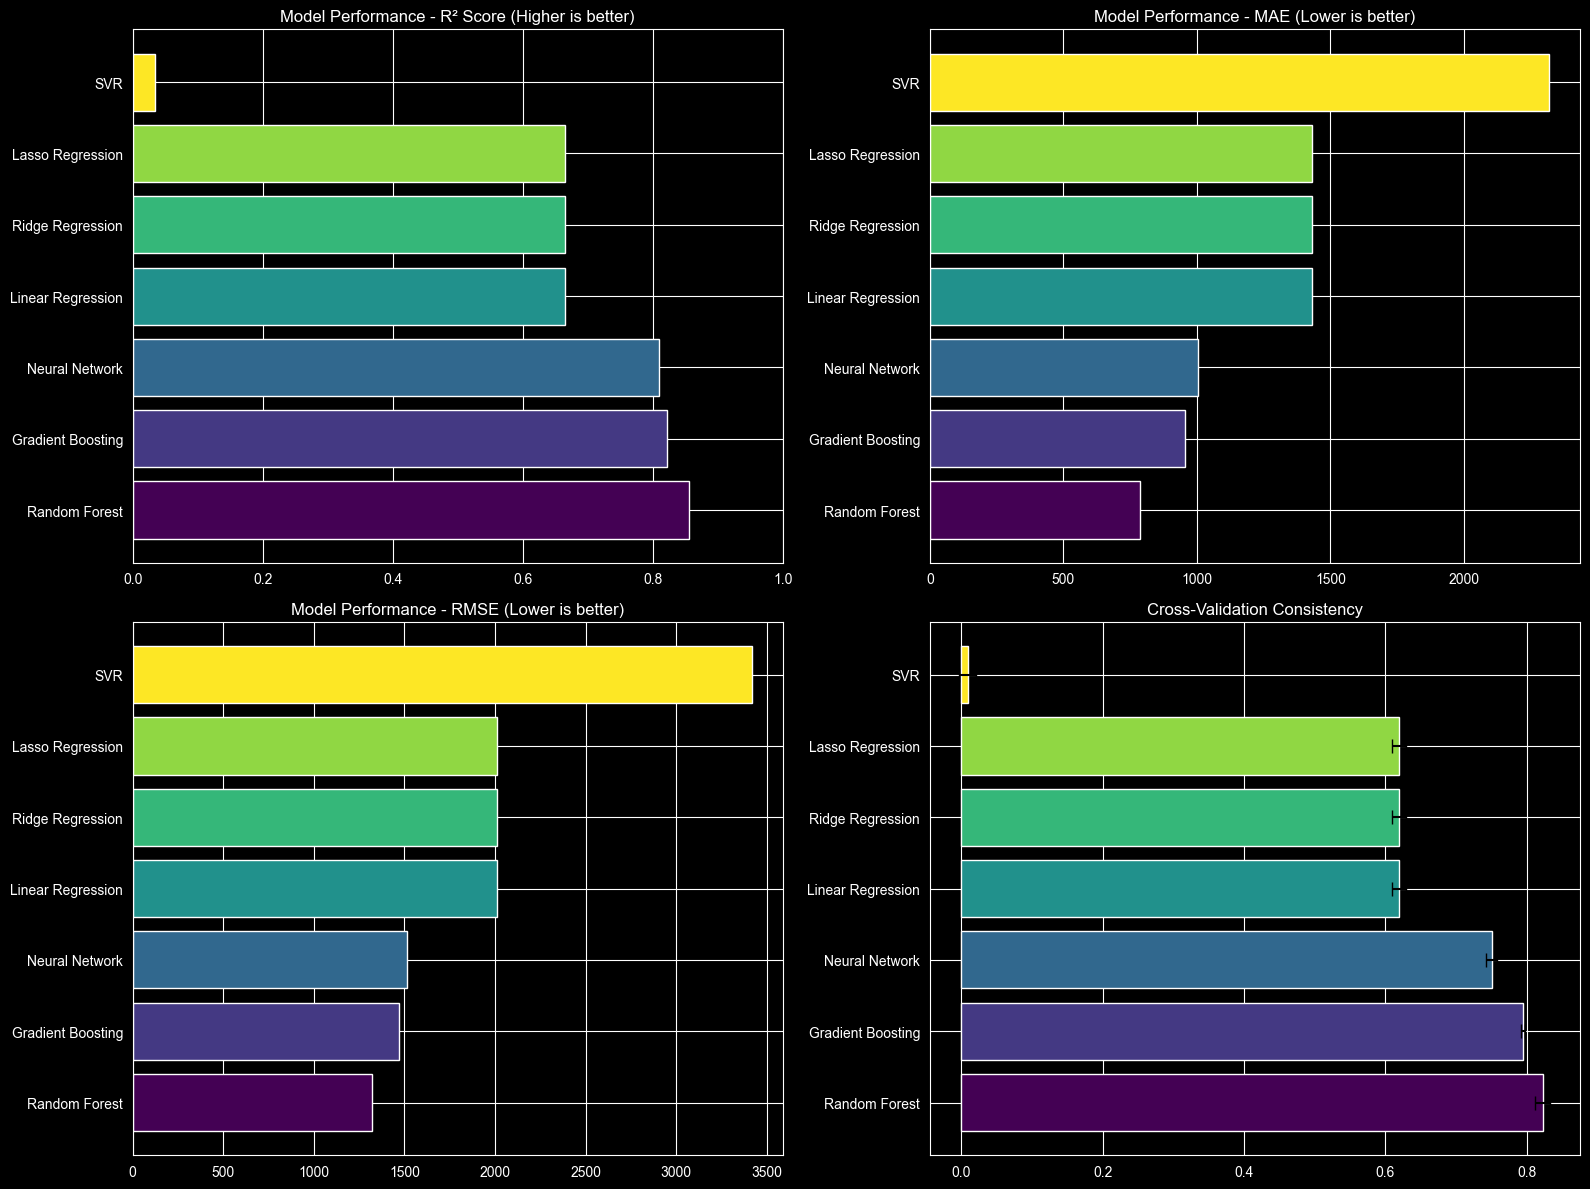


Generating Feature Importance Plot...


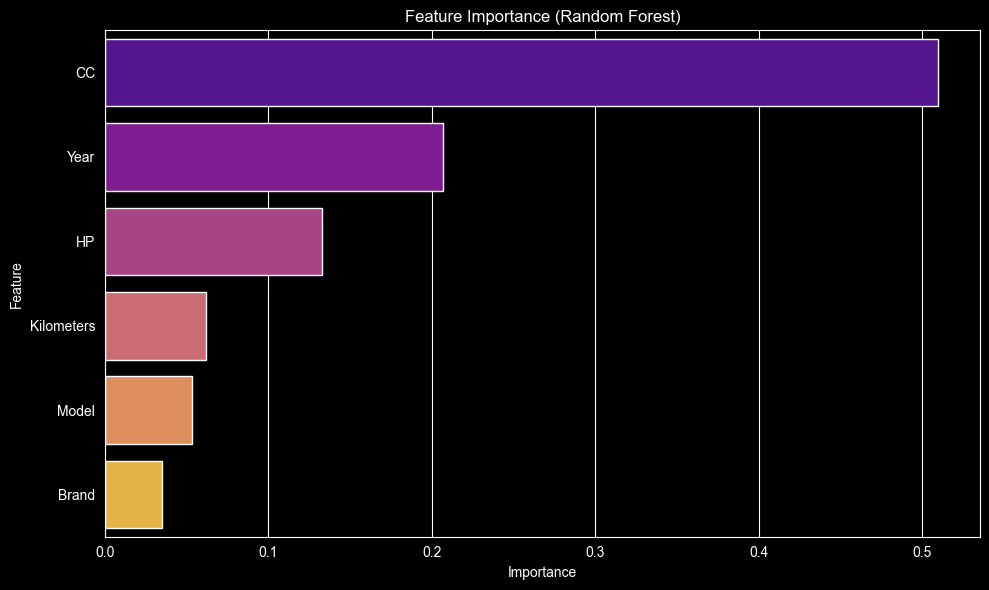

Top 5 Drivers of Price:
      Feature  Importance
2          CC    0.509818
0        Year    0.206838
3          HP    0.132998
1  Kilometers    0.062157
5       Model    0.053196


In [7]:
# Plot Model Comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
colors = plt.cm.viridis(np.linspace(0, 1, len(results_df)))

# R2 Score
ax1 = axes[0, 0]
ax1.barh(results_df['Model'], results_df['R² Score'], color=colors)
ax1.set_title('Model Performance - R² Score (Higher is better)')
ax1.set_xlim(0, 1)

# MAE
ax2 = axes[0, 1]
ax2.barh(results_df['Model'], results_df['MAE'], color=colors)
ax2.set_title('Model Performance - MAE (Lower is better)')

# RMSE
ax3 = axes[1, 0]
ax3.barh(results_df['Model'], results_df['RMSE'], color=colors)
ax3.set_title('Model Performance - RMSE (Lower is better)')

# CV Score
ax4 = axes[1, 1]
ax4.barh(results_df['Model'], results_df['CV R² Mean'], xerr=results_df['CV R² Std'], color=colors, capsize=5)
ax4.set_title('Cross-Validation Consistency')

plt.tight_layout()
plt.savefig('visualizations/model_comparison.png')
plt.show()

# --- Feature Importance (Random Forest) ---
print("\nGenerating Feature Importance Plot...")
rf_model = joblib.load('models/model_random_forest.pkl')
feature_names = X.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='plasma')
plt.title('Feature Importance (Random Forest)')
plt.tight_layout()
plt.savefig('visualizations/feature_importance.png')
plt.show()

print("Top 5 Drivers of Price:")
print(importance_df.head())